# Task-1: Read and display CIFAR-10 image files

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader           # lets us load data in batches
#from torchvision import datasets, transforms

import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results

%matplotlib inline

## Define transform
As part of the loading process, we can apply multiple transformations (reshape, convert to tensor, normalize, etc.) to the incoming data. The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## Load the training set

In [3]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_data

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

## Load the testing set

In [4]:
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_data

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [5]:
#---------------examining image-------------------
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([3, 32, 32]) 
Label: 6


In [6]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Batch loading with DataLoader

In [8]:
batch_size = 100
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

## Visualizing some images

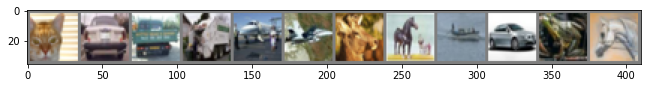

cat   automobile truck truck airplane airplane deer  horse ship  automobile frog  horse


In [12]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(11,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get a training batch (100 images)
dataiter = iter(train_loader)
images, labels = next(dataiter)

# showing 12 images
imshow(torchvision.utils.make_grid(images[:12], nrow=12))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(12)))


# Task-2: Creating 2-layer neural network structure
Our input size is 3072 once we flatten the incoming 3x32x32 tensors. Our output size represents the 10 possible classes. We'll set our hidden layers to 120

In [13]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=3072, out_sz=10, layers=120):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers)
        self.fc2 = nn.Linear(layers,out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [14]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=3072, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

## Counting the model parameters

In [15]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [16]:
count_parameters(model)

368640
   120
  1200
    10
______
369970


# Task-3 & 4: Defining loss function & optimizer

In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Flatten the training data

In [18]:
# Load the first batch, print its shape
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break

Batch shape: torch.Size([100, 3, 32, 32])


In [19]:
images = torch.flatten(images, 1)
images.shape

torch.Size([100, 3072])

## Task-5: Training the model

In [22]:
import time
start_time = time.time()

epochs = 100
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(torch.flatten(X_train, 1))  # flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(torch.flatten(X_test, 1))  # flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [ 20000/60000]  loss: 1.42942703  accuracy:  50.765%
epoch:  0  batch:  400 [ 40000/60000]  loss: 1.39574921  accuracy:  50.990%
epoch:  1  batch:  200 [ 20000/60000]  loss: 1.47436893  accuracy:  51.640%
epoch:  1  batch:  400 [ 40000/60000]  loss: 1.22446680  accuracy:  51.800%
epoch:  2  batch:  200 [ 20000/60000]  loss: 1.45712984  accuracy:  51.870%
epoch:  2  batch:  400 [ 40000/60000]  loss: 1.49207580  accuracy:  52.593%
epoch:  3  batch:  200 [ 20000/60000]  loss: 1.33313191  accuracy:  52.685%
epoch:  3  batch:  400 [ 40000/60000]  loss: 1.28529191  accuracy:  52.892%
epoch:  4  batch:  200 [ 20000/60000]  loss: 1.56661487  accuracy:  54.285%
epoch:  4  batch:  400 [ 40000/60000]  loss: 1.47228205  accuracy:  53.727%
epoch:  5  batch:  200 [ 20000/60000]  loss: 1.39139247  accuracy:  54.100%
epoch:  5  batch:  400 [ 40000/60000]  loss: 1.29619205  accuracy:  54.415%
epoch:  6  batch:  200 [ 20000/60000]  loss: 1.15228081  accuracy:  55.055%
epoch:  6  b

epoch: 54  batch:  200 [ 20000/60000]  loss: 0.89000475  accuracy:  70.700%
epoch: 54  batch:  400 [ 40000/60000]  loss: 0.74410391  accuracy:  70.260%
epoch: 55  batch:  200 [ 20000/60000]  loss: 0.93886071  accuracy:  71.360%
epoch: 55  batch:  400 [ 40000/60000]  loss: 0.87940753  accuracy:  70.377%
epoch: 56  batch:  200 [ 20000/60000]  loss: 0.92746794  accuracy:  71.210%
epoch: 56  batch:  400 [ 40000/60000]  loss: 0.95302582  accuracy:  70.757%
epoch: 57  batch:  200 [ 20000/60000]  loss: 0.97477514  accuracy:  71.255%
epoch: 57  batch:  400 [ 40000/60000]  loss: 0.75617087  accuracy:  70.897%
epoch: 58  batch:  200 [ 20000/60000]  loss: 0.74034727  accuracy:  71.125%
epoch: 58  batch:  400 [ 40000/60000]  loss: 0.92152262  accuracy:  71.110%
epoch: 59  batch:  200 [ 20000/60000]  loss: 0.87486649  accuracy:  71.655%
epoch: 59  batch:  400 [ 40000/60000]  loss: 0.71412921  accuracy:  71.317%
epoch: 60  batch:  200 [ 20000/60000]  loss: 0.81005508  accuracy:  71.865%
epoch: 60  b

## Saving the model

In [23]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

## Plot the loss and accuracy comparisons

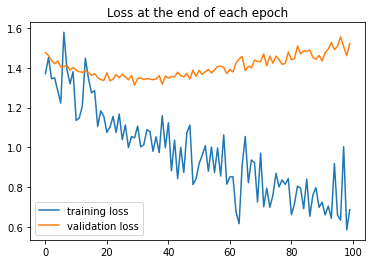

In [24]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

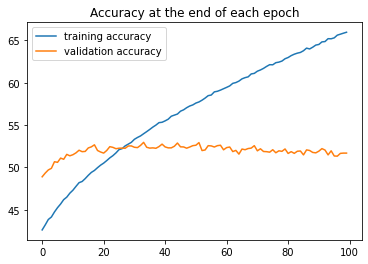

In [25]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

# Evaluate the performance

In [27]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [28]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 5169/10000 =  51.690%


# Display confusion matrix

In [29]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 585   35   77   33   50   18   16   32  101   41]
 [  35  611   11   21   14    9   20   19   71  156]
 [  63   30  447   96  161   95   94   66   26   24]
 [  22   21   78  304   52  188   79   72   26   29]
 [  41   21  131   77  463   85   95  106   21   20]
 [  17   18   92  229   60  413   63   92   14   22]
 [  20   17   77  118   78   65  585   35   11   20]
 [  24   19   52   58   78   71   21  530   16   44]
 [ 139   68   16   20   27   28   14   15  655   68]
 [  54  160   19   44   17   28   13   33   59  576]]
